In [23]:
from sigelmsync import sigelmsync
from starkelmsync import starkelmsync
import matplotlib.cm as cm
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import numpy as np
import os
#
from matplotlib import rc
plt.style.use('helvet')
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{tgheros}',    # helvetica font
    r'\usepackage{sansmath}',   # math-font matching  helvetica
    r'\sansmath'                # actually tell tex to use it!
    r'\usepackage{siunitx}',    # micro symbols
    r'\sisetup{detect-all}',    # force siunitx to use the fonts
]
#

In [2]:
def smooth(data,N=5):
    return np.convolve(data,np.ones(N)/N,'same');

def smooth2d(data,N):
    for i in range(len(data[0,:])):
        data[:,i] = smooth(data[:,i],N)
    return data

#### Settings for analysis

In [37]:
shotnr=30554
ti=1.8
tf=2.8
preft=0.002
suft=0.008
refside = 'out'
divside = refside
divitem = 'jsat'
elm_exper = "guimas"
mintime = -preft*1e3
maxtime = suft*1e3

In [99]:
def two_starksync(shotnr, ti, tf, preft=0.002, suft=0.008,
                  refside='in', divside='in', divitem='jsat',
                  ref_exper='AUGD', elm_exper='AUGD',
                  minydiv=-5, maxydiv=20, divtickfreq=5):

    """Ref and divertor data ELM Conditional Averaging
    
    """
    
    graphsets = {'minydiv': minydiv, 'maxydiv': maxydiv}
    
    ####Read Data
    ####Parameters for Refplot
    if refside == 'in':
        refsgr = "HFSR"
        separatrix_signal = "Rin"
        minyval = 1.04
        maxyval = 1.17
    else:
        refsgr = "LFSR"
        separatrix_signal = "Raus"
        minyval = 2.08
        maxyval = 2.21

    th, rh = sigelmsync(shotnr, "RDL", refsgr, ti=ti, tf=tf, preft=preft, suft=suft, elm_exper=elm_exper)

    ##Don't use all data
    nchans = 11
    rh = rh[1:nchans]

    ## Check densities used (shortcut without dd)
    mindens = 0.5
    maxdens = 6.0
    dens = np.linspace(mindens, maxdens ,12)

    ####Separatrix
    trin, rin = sigelmsync(shotnr, "FPG", separatrix_signal, ti=ti, tf=tf,
                           preft=preft, suft=suft,
                           elm_exper=elm_exper)

    ######Jsat
    t, s, m = starkelmsync(shotnr, ti=ti, tf=tf,
                           item=divitem, side=divside,
                           preft=preft, suft=suft,
                           elm_exper=elm_exper)
    
    
    ######    
    fig = plt.figure(figsize=(3.0, 2.5))

    gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[4, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    ax1.text(0.03, 0.85, 'a)', transform = ax1.transAxes)
    ax2.text(0.03, 0.85, 'b)', transform = ax2.transAxes, color='white')

    ######################################

    ## Check densities used (shortcut without dd)
    mindens = 0.5
    maxdens = 6.0
    dens = np.linspace(mindens, maxdens ,12)
    
    indr = sorted(xrange(len(trin)), key=lambda ix: trin[ix])
    trinsort = trin[indr]
    rinsort = rin[indr]
    ax1.scatter(trin*1e3, rin, color='k', edgecolors='k', s=0.7)
    ax1.fill_between(trinsort*1e3, rinsort, 1.5, color='black', alpha=0.25)

    fth = []
    frh = []
    fne = []

    for i in range(len(rh)):
        fth.append(th*1e3)
        frh.append(rh[i])
        fne.append(dens[i] * np.ones(len(th)))

    ########
    fth = np.concatenate(fth)
    frh = np.concatenate(frh)
    fne = np.concatenate(fne)

    ########
    cmap = cm.get_cmap('jet')
    sc = ax1.scatter(fth, frh, c=fne, s=2.0, lw=0, cmap=cmap)

    ###Colorbar
    axins = inset_axes(ax1,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
               )
    cbar = plt.colorbar(sc, cax=axins, ticks=(np.arange(0.0, max(fne)+1.0, 1.0)))
    cbar.set_label(r'$\mathrm{n_{e}\,[10^{19}m^{-3}]}$')

    ax1.set_ylim([minyval, maxyval])

    #Inner wall
    ax1.hlines(1.045, mintime, maxtime, color='black', lw=3)
    
    ax1.set_ylabel(r"$\mathrm{R\,[m]}$")

    plt.setp(ax1.get_xticklabels(), visible=False)

    ######################################

    #Maximum vertical value for the emapping
    if divitem == 'nev':
        vmax = 80
        cbticks = np.linspace(20, vmax, 4)
        clblabelstr = "$\mathrm{n_{e,v}\,[10^{20}m^{-3}]}$"
    elif divitem == 'te':
        vmax = 20 #Limit it to 20eV
        cbticks = np.linspace(vmax/4, vmax, 4)
        clblabelstr = r"$\mathrm{t_{e}\,[eV]}$"
    elif divitem == 'net':
        vmax = np.min([24, np.floor(m.max())])
        cbticks = np.linspace(vmax/4, vmax, 4)
        clblabelstr = r"$\mathrm{n_{e,p}\,[10^{19}m^{-3}]}$"
    else: #Default to jsat
        vmax = 21
        cbticks = np.linspace(0, vmax, 5)
        clblabelstr = r"$\mathrm{\Gamma_{D^{+}}\,[10^{22}m^{-2}s^{-1}]}$"

    sc2 = ax2.pcolormesh(t*1e3, s, m, shading='goraud', vmax=vmax, vmin=0.0, cmap=cmap)
    ###Colorbar    
    axins = inset_axes(ax2,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
               )

    cbar = plt.colorbar(sc2, cax=axins, ticks=(np.arange(0.0, vmax+1.0, 5.0)))
    cbar.set_label(r"$\mathrm{\Gamma_{D^{+}}\,[10^{22}m^{-2}s^{-1}]}$")
        
    ax2.set_ylim([graphsets['minydiv'], graphsets['maxydiv']])
    ax2.set_xlim(-preft*1e3, suft*1e3)
    ax2.set_yticks((np.arange(graphsets['minydiv'], graphsets['minydiv']+1.0, divtickfreq)))
    
    ax2.set_ylabel(r"$\mathrm{\Delta S\,[cm]}$")
    ax2.set_xlabel(r"$\mathrm{t-t_{ELM}\,[ms]}$")
    ax2.hlines(0, mintime, maxtime, color='white')

    ax2.set_xticks(np.arange(mintime, maxtime+1, 2.0))
    ax2.set_xlim([-preft*1e3, suft*1e3])
    
    plt.subplots_adjust(left=0.18, right=0.97, bottom=0.16, top=0.97, wspace=0.10, hspace=0.05)

    #Output file
    elmdir = os.path.expanduser('~') + "/ELM/"
    if not os.path.exists(elmdir):
        os.makedirs(elmdir)
    shotdir = elmdir + str(shotnr) + '/'
    if not os.path.exists(shotdir):
        os.makedirs(shotdir)

    filename = shotdir + "ss_" + str(shotnr) + "_" + str(ti) + "_" + str(tf) + "_" + refside + divside + ".png"
    plt.savefig(filename, format="png", dpi=300)
    print "Wrote: " + filename   
        
    plt.show()

## #30554, N seeding 

### Shot #30554, Phase I

Wrote: /home/guimas/ELM/30554/ss_30554_1.8_2.8_inin.png


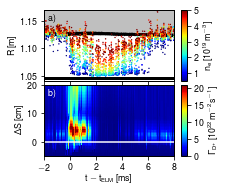

Wrote: /home/guimas/ELM/30554/ss_30554_1.8_2.8_outout.png


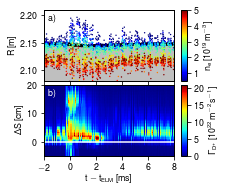

In [94]:
shotnr = 30554
ti = 1.8
tf = 2.8
preft = 0.002
suft = 0.008
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in', elm_exper='guimas')
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out', elm_exper='guimas')

### Shot #30554, Phase II

Wrote: /home/guimas/ELM/30554/ss_30554_3.0_3.5_inin.png


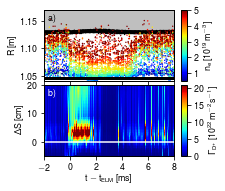

Wrote: /home/guimas/ELM/30554/ss_30554_3.0_3.5_outout.png


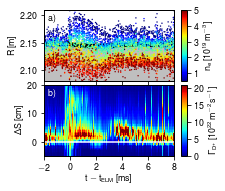

In [81]:
shotnr = 30554
ti = 3.0
tf = 3.5
preft = 0.002
suft = 0.008
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in', elm_exper='guimas')
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out', elm_exper='guimas')

### Shot #30554, Phase III, N seeding

In [ ]:
shotnr = 30554
ti = 3.0
tf = 3.5
preft = 0.002
suft = 0.008
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in', elm_exper='guimas')
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out', elm_exper='guimas')

## Shot #32234, Ne seeding experiment

### Neon seeding 32234, no seeding

Wrote: /home/guimas/ELM/32234/ss_32234_2.2_2.5_inin.png


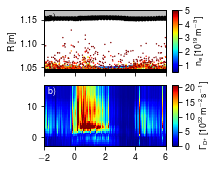

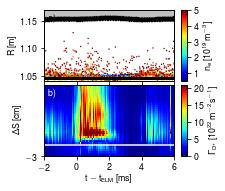

Wrote: /home/guimas/ELM/32234/ss_32234_2.2_2.5_outout.png


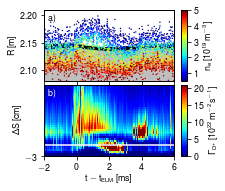

In [100]:
shotnr = 32234
preft = 0.002
suft = 0.006
ti = 2.2
tf = 2.5
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in',
              minydiv=-3, maxydiv=17, divtickfreq=5)
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out',
              minydiv=-3, maxydiv=17, divtickfreq=5)

### Neon seeding 32234, with seeding

Wrote: /home/guimas/ELM/32234/ss_32234_3.3_4.0_inin.png


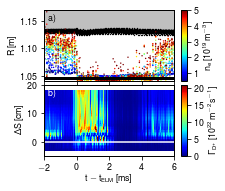

Wrote: /home/guimas/ELM/32234/ss_32234_3.3_4.0_outout.png


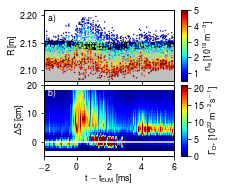

In [83]:
shotnr = 32234
preft = 0.002
suft = 0.006
ti = 3.3
tf = 4.0
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='in', divside='in')
two_starksync(shotnr, ti, tf, preft=preft, suft=suft, refside='out', divside='out')